/var/folders/k7/g4sgs1kn7w763_44_b21v97w0000gn/T/ipykernel_70954/2665195536.py:93: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  pfade = np.array([Image.open('Pferd1.jpg'),Image.open('Pferd2.jpg'),Image.open('Pferd3.jpg'),Image.open('Pferd4.jpg'),Image.open('Pferd5.jpg'),Image.open('Pferd6.jpg'),Image.open('Pferd7.jpg'),Image.open('Pferd8.jpg'),Image.open('Pferd9.jpg'),Image.open('Pferd10.jpg')],dtype=object)


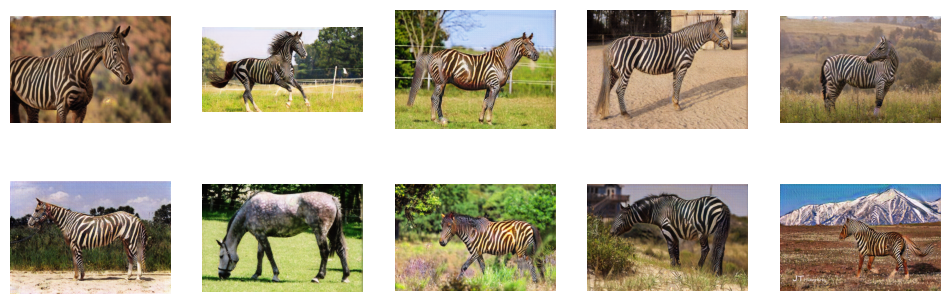

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
                                               
class ResNetBlock(nn.Module): 

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

netG = ResNetGenerator()

model_path = 'horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

netG.eval()

from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([transforms.Resize(256),transforms.ToTensor()])


pfade = np.array([Image.open('Pferd1.jpg'),Image.open('Pferd2.jpg'),Image.open('Pferd3.jpg'),Image.open('Pferd4.jpg'),Image.open('Pferd5.jpg'),Image.open('Pferd6.jpg'),Image.open('Pferd7.jpg'),Image.open('Pferd8.jpg'),Image.open('Pferd9.jpg'),Image.open('Pferd10.jpg')],dtype=object)
output = []

for i in range (0,10):
    img = pfade[i]

    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)

    batch_out = netG(batch_t)

    out_t = (batch_out.data.squeeze() + 1.0) / 2.0
    out_img = transforms.ToPILImage()(out_t)

    output.append(out_img) # so auch in Aufgabe 1 umsetzen!

w = 10
h = 10
fig = plt.figure(figsize=(12, 4))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = output[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

